Section 1: Chargement et Exploration des Données
-------------------------------------------------
Dataset loaded with shape: (10000, 8)

First 5 rows of the dataset:
   user_id  joinedDate                            joinedCourses  \
0        1  2022-08-28  Machine Learning, CSS, Excel, SQL, HTML   
1        2  2023-12-04  Data Science, Excel, Python, JavaScript   
2        3  2023-04-10          JavaScript, Python, Excel, Java   
3        4  2022-01-30              AI, Machine Learning, Excel   
4        5  2022-09-07                                   Python   

                               skills  \
0                           HTML, SQL   
1   HTML, CSS, JavaScript, Excel, SQL   
2                     HTML, CSS, Java   
3  HTML, Excel, SQL, Java, Blockchain   
4                 CSS, JavaScript, AI   

                                      desired_skills  isVerified  \
0  CSS, Java, Machine Learning, Blockchain, Data ...       False   
1              JavaScript, Python, Java, Node.j

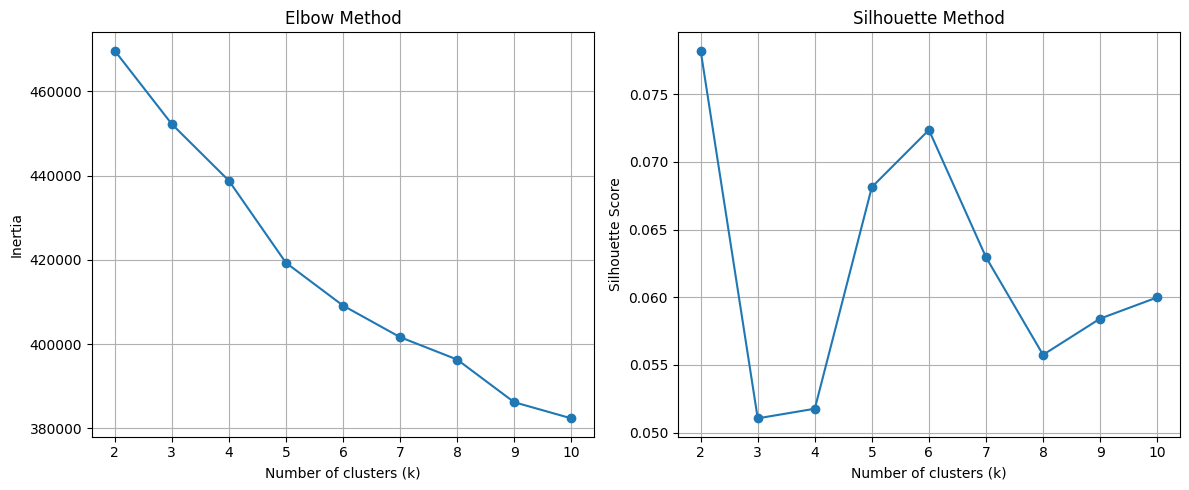

Recommended optimal number of clusters: 2 (based on highest silhouette score)


Section 7: Clustering avec K-Means
-------------------------------------------------
Using optimal number of clusters: 2
K-means clustering completed. Clusters distribution:
cluster
1    8977
0    1023
Name: count, dtype: int64

First 5 rows with cluster assignments:
   user_id joinedDate                            joinedCourses  \
0        1 2022-08-28  Machine Learning, CSS, Excel, SQL, HTML   
1        2 2023-12-04  Data Science, Excel, Python, JavaScript   
2        3 2023-04-10          JavaScript, Python, Excel, Java   
3        4 2022-01-30              AI, Machine Learning, Excel   
4        5 2022-09-07                                   Python   

                               skills  \
0                           HTML, SQL   
1   HTML, CSS, JavaScript, Excel, SQL   
2                     HTML, CSS, Java   
3  HTML, Excel, SQL, Java, Blockchain   
4                 CSS, JavaScript, AI   

        

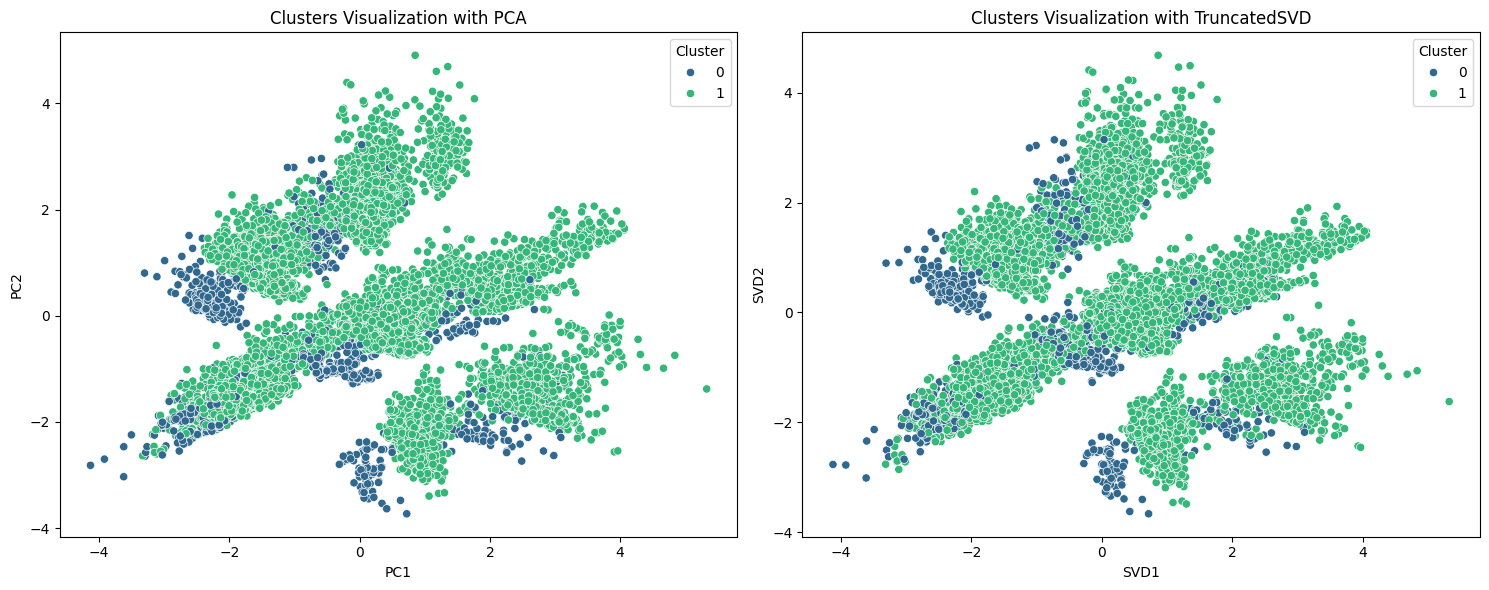



Section 9: Analyse des Caractéristiques des Clusters
-------------------------------------------------


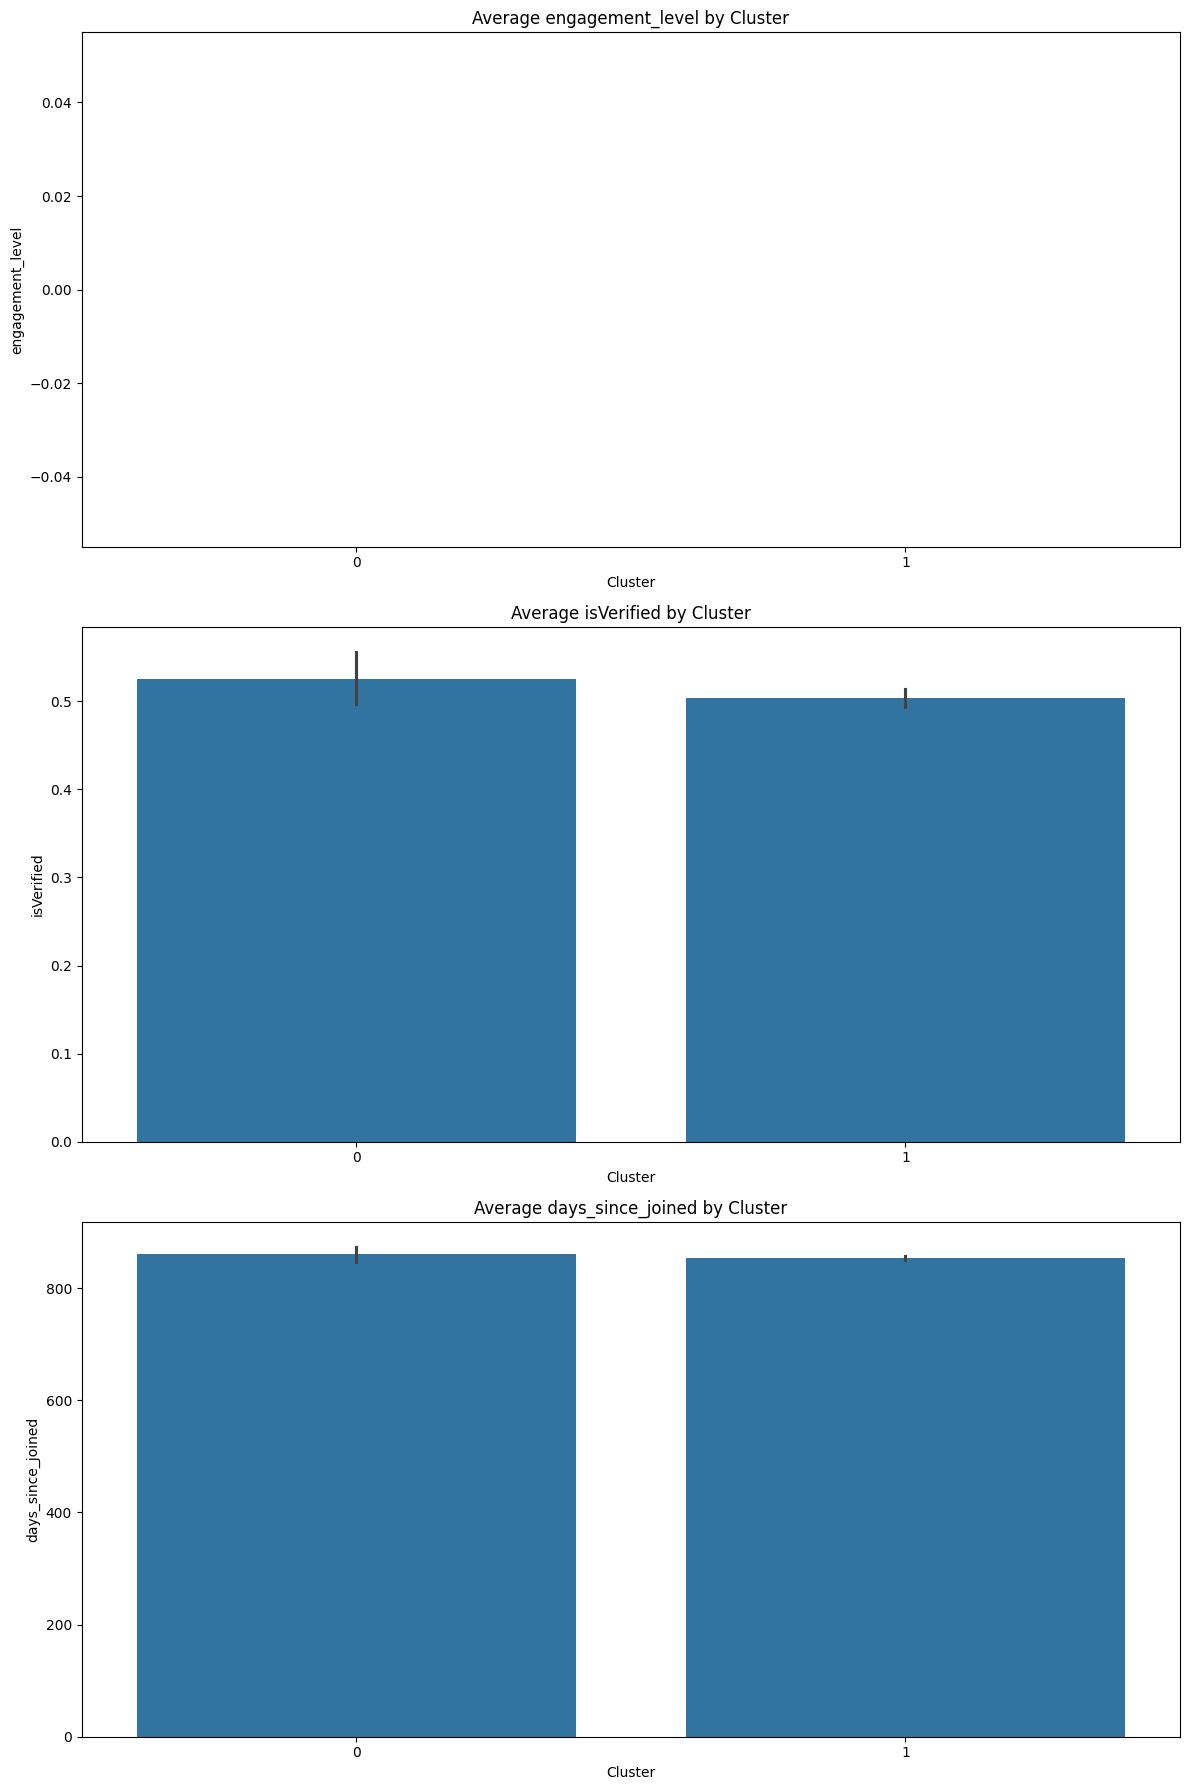


Mean values of numerical features by cluster:
         engagement_level  isVerified  days_since_joined
cluster                                                 
0                     0.0    0.525904         860.777126
1                     0.0    0.503732         853.981174

Top skills by cluster:

Cluster 0 top skills:
Data Science HTML    614
Excel                434
JavaScript           330
CSS                  299
SQL                  291
Name: count, dtype: int64

Cluster 1 top skills:
Excel         3136
JavaScript    2546
CSS           2417
Python        1746
SQL           1441
Name: count, dtype: int64

Top courses by cluster:

Cluster 0 top courses:
Python        108
Node.js       105
AI            105
Blockchain    104
JavaScript    104
Name: count, dtype: int64

Cluster 1 top courses:
CSS             941
Excel           923
SQL             921
Data Science    914
Node.js         908
Name: count, dtype: int64


Section 10: KNN pour la Prédiction des Compétences Désirées
------

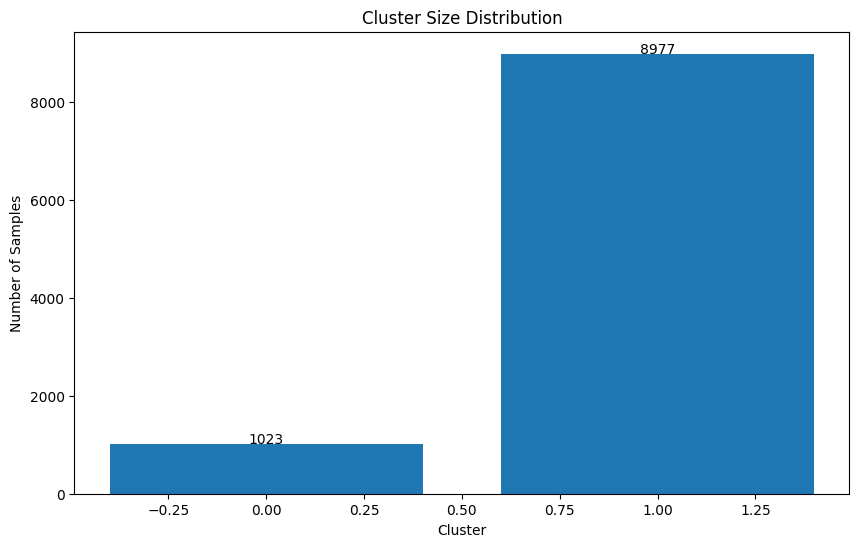



Section 12: Interprétation des Résultats
-------------------------------------------------
Cluster Profiles:
----------------

Cluster 0 (1023 users, 10.23% of total):
- Common skills: Data Science, HTML, CSS
- Popular courses: CSS, AI, Data Science
- Desired skills: Blockchain, AI, Data Science

Cluster 1 (8977 users, 89.77% of total):
- Common skills: HTML, Excel, CSS
- Popular courses: HTML, Excel, Data Science
- Desired skills: Blockchain, AI, Data Science


Section 13: Utilisation du Modèle pour la Prédiction
-------------------------------------------------
Example: Predicting cluster and desired skills for a new user
New user profile:
  skills: Python, Data Science, Machine Learning
  joinedCourses: Introduction to AI, Python Programming
  engagement_level: 2
  isVerified: 1
  days_since_joined: 30

To make a real prediction, you would need to:
1. Process the new user's text features (skills, courses) using the same vectorizers
2. Create the same feature set as used in trainin

In [3]:
# User Segmentation Clustering Analysis
# Objectif: Segmenter les utilisateurs en groupes basés sur leurs compétences, cours, et engagement

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import silhouette_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Section 1: Chargement et Exploration des Données
print("Section 1: Chargement et Exploration des Données")
print("-------------------------------------------------")

# Load the dataset
def load_dataset():
    try:
        # Try to read directly from Google Drive if mounted
        from google.colab import drive
        df = pd.read_csv('edited_skill_exchange_dataset.csv')

    except:
        try:
            # If not mounted, try to upload from local
            from google.colab import files
            uploaded = files.upload()
            file_name = list(uploaded.keys())[0]
            df = pd.read_csv(file_name)
        except:
            print("Please upload the 'edited_skill_exchange_dataset (1).csv' file manually")
            return None

    print(f"Dataset loaded with shape: {df.shape}")
    return df

# Load the dataset
df = load_dataset()

# Display basic information about the dataset
if df is not None:
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    print("\nDataset information:")
    print(df.info())

    print("\nDescriptive statistics:")
    print(df.describe())

    print("\nMissing values per column:")
    print(df.isnull().sum())

# Section 2: Préparation des Données
print("\n\nSection 2: Préparation des Données")
print("-------------------------------------------------")

def prepare_data(df):
    if df is None:
        return None

    # Create a copy to avoid modifying the original dataframe
    data = df.copy()

    # Check the columns in the dataset
    print("Available columns in the dataset:", data.columns.tolist())

    # Define the expected columns (adjust based on your actual dataset)
    expected_columns = ['skills', 'joinedCourses', 'engagement_level', 'isVerified', 'joinedDate', 'desired_skills']

    # Check if all expected columns exist
    missing_columns = [col for col in expected_columns if col not in data.columns]
    if missing_columns:
        print(f"Warning: The following expected columns are missing: {missing_columns}")
        print("Will proceed with available columns.")

    # Convert joinedDate to days since joined (if column exists)
    if 'joinedDate' in data.columns:
        try:
            # Convert to datetime and calculate days since joined
            current_date = datetime.now()
            data['joinedDate'] = pd.to_datetime(data['joinedDate'])
            data['days_since_joined'] = (current_date - data['joinedDate']).dt.days
            print("Successfully converted joinedDate to days_since_joined")
        except Exception as e:
            print(f"Error processing joinedDate: {e}")
            if 'joinedDate' in data.columns:
                # If conversion fails, drop the column
                data = data.drop('joinedDate', axis=1)

    # Handle missing values
    for column in data.columns:
        if data[column].dtype == 'object':
            # Fill missing text values with empty string
            data[column] = data[column].fillna('')
        else:
            # Fill missing numerical values with mean
            data[column] = data[column].fillna(data[column].mean())

    # Convert isVerified to binary (if exists)
    if 'isVerified' in data.columns:
        if data['isVerified'].dtype == 'object':
            data['isVerified'] = data['isVerified'].map({'True': 1, 'False': 0, True: 1, False: 0})
        data['isVerified'] = data['isVerified'].fillna(0).astype(int)

    # Convert engagement_level to numeric (if exists)
    if 'engagement_level' in data.columns:
        if data['engagement_level'].dtype == 'object':
            engagement_map = {'low': 0, 'medium': 1, 'high': 2}
            data['engagement_level'] = data['engagement_level'].map(engagement_map)
            data['engagement_level'] = data['engagement_level'].fillna(0).astype(int)

    print("Data preparation completed")
    return data

# Prepare the data
prepared_df = prepare_data(df)

if prepared_df is not None:
    print("\nFirst 5 rows after preparation:")
    print(prepared_df.head())

# Section 3: Traitement des Caractéristiques Textuelles
print("\n\nSection 3: Traitement des Caractéristiques Textuelles")
print("-------------------------------------------------")

def process_text_features(df):
    if df is None:
        return None, None, None

    text_features = {}

    # Process skills with TF-IDF (if exists)
    if 'skills' in df.columns:
        print("Processing 'skills' with TF-IDF...")
        tfidf_skills = TfidfVectorizer(max_features=100)
        skills_matrix = tfidf_skills.fit_transform(df['skills'].fillna(''))
        skills_df = pd.DataFrame(
            skills_matrix.toarray(),
            columns=[f'skill_{i}' for i in range(skills_matrix.shape[1])]
        )
        text_features['skills'] = skills_df
        print(f"Skills processed: {skills_df.shape[1]} features extracted")

    # Process joinedCourses with Count Vectorizer (if exists)
    if 'joinedCourses' in df.columns:
        print("Processing 'joinedCourses' with CountVectorizer...")
        count_vec = CountVectorizer(max_features=100)
        courses_matrix = count_vec.fit_transform(df['joinedCourses'].fillna(''))
        courses_df = pd.DataFrame(
            courses_matrix.toarray(),
            columns=[f'course_{i}' for i in range(courses_matrix.shape[1])]
        )
        text_features['courses'] = courses_df
        print(f"Joined courses processed: {courses_df.shape[1]} features extracted")

    # Process desired_skills with TF-IDF (if exists)
    if 'desired_skills' in df.columns:
        print("Processing 'desired_skills' with TF-IDF...")
        tfidf_desired = TfidfVectorizer(max_features=100)
        desired_matrix = tfidf_desired.fit_transform(df['desired_skills'].fillna(''))
        desired_df = pd.DataFrame(
            desired_matrix.toarray(),
            columns=[f'desired_{i}' for i in range(desired_matrix.shape[1])]
        )
        text_features['desired'] = desired_df
        print(f"Desired skills processed: {desired_df.shape[1]} features extracted")

    # Get numerical features for clustering
    numerical_cols = []
    if 'engagement_level' in df.columns:
        numerical_cols.append('engagement_level')
    if 'isVerified' in df.columns:
        numerical_cols.append('isVerified')
    if 'days_since_joined' in df.columns:
        numerical_cols.append('days_since_joined')

    if not numerical_cols:
        print("Warning: No numerical features found for clustering")
        numerical_df = pd.DataFrame()
    else:
        print(f"Using numerical features: {numerical_cols}")
        numerical_df = df[numerical_cols].copy()

    # Combine all features for clustering
    feature_dfs = [numerical_df] + list(text_features.values())
    all_features_df = pd.concat(feature_dfs, axis=1)

    print(f"Final feature matrix shape: {all_features_df.shape}")
    return all_features_df, text_features, numerical_df

# Process the text features
features_df, text_features, numerical_df = process_text_features(prepared_df)

if features_df is not None:
    print("\nFirst 5 rows of processed features:")
    print(features_df.head())

# Section 4: Normalisation des Caractéristiques
print("\n\nSection 4: Normalisation des Caractéristiques")
print("-------------------------------------------------")

def normalize_features(df):
    if df is None or df.empty:
        return None

    # Create a copy of the dataframe
    normalized_df = df.copy()

    # Normalize all columns using StandardScaler
    scaler = StandardScaler()
    normalized_values = scaler.fit_transform(normalized_df)
    normalized_df = pd.DataFrame(normalized_values, columns=normalized_df.columns)

    print(f"Features normalized. Shape: {normalized_df.shape}")
    return normalized_df, scaler

# Normalize the features
normalized_features, scaler = normalize_features(features_df)

if normalized_features is not None:
    print("\nFirst 5 rows of normalized features:")
    print(normalized_features.head())

# Section 5: Réduction de Dimension pour la Visualisation
print("\n\nSection 5: Réduction de Dimension pour la Visualisation")
print("-------------------------------------------------")

def apply_dimension_reduction(df):
    if df is None or df.empty:
        return None, None

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df)
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

    print(f"PCA applied. Explained variance ratio: {pca.explained_variance_ratio_}")

    # If we have many sparse features (like from TF-IDF), also try TruncatedSVD
    if df.shape[1] > 10:
        print("Also applying TruncatedSVD for comparison...")
        svd = TruncatedSVD(n_components=2)
        svd_result = svd.fit_transform(df)
        svd_df = pd.DataFrame(svd_result, columns=['SVD1', 'SVD2'])
        print(f"TruncatedSVD applied. Explained variance ratio: {svd.explained_variance_ratio_}")
    else:
        svd_df = None

    return pca_df, svd_df

# Apply dimension reduction
pca_df, svd_df = apply_dimension_reduction(normalized_features)

if pca_df is not None:
    print("\nFirst 5 rows of PCA result:")
    print(pca_df.head())

# Section 6: Détermination du Nombre Optimal de Clusters
print("\n\nSection 6: Détermination du Nombre Optimal de Clusters")
print("-------------------------------------------------")

def find_optimal_clusters(df):
    if df is None or df.empty:
        return None

    # Calculate inertia (within-cluster sum of squares) for different k values
    inertia = []
    silhouette_scores = []
    k_range = range(2, 11)

    for k in k_range:
        # Initialize and fit K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(df)

        # Store inertia
        inertia.append(kmeans.inertia_)

        # Calculate silhouette score
        if len(set(kmeans.labels_)) > 1:  # Ensure we have at least 2 clusters
            silhouette_scores.append(silhouette_score(df, kmeans.labels_))
        else:
            silhouette_scores.append(0)

    # Plot elbow method
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertia, 'o-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'o-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Determine the optimal k value (simple approach)
    optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"Recommended optimal number of clusters: {optimal_k} (based on highest silhouette score)")

    return optimal_k

# Find the optimal number of clusters
optimal_k = find_optimal_clusters(normalized_features)

# Section 7: Clustering avec K-Means
print("\n\nSection 7: Clustering avec K-Means")
print("-------------------------------------------------")

def apply_kmeans_clustering(df, n_clusters=3):
    if df is None or df.empty:
        return None, None

    # If optimal_k was not determined, use the provided default
    if n_clusters is None:
        n_clusters = 3
        print(f"Using default number of clusters: {n_clusters}")
    else:
        print(f"Using optimal number of clusters: {n_clusters}")

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df)

    # Create a DataFrame with cluster assignments
    cluster_df = pd.DataFrame({'cluster': cluster_labels})

    print(f"K-means clustering completed. Clusters distribution:")
    print(cluster_df['cluster'].value_counts())

    return kmeans, cluster_labels

# Apply K-means clustering
kmeans_model, cluster_labels = apply_kmeans_clustering(normalized_features, optimal_k)

# Add cluster labels to the original dataframe for analysis
if prepared_df is not None and cluster_labels is not None:
    prepared_df['cluster'] = cluster_labels
    print("\nFirst 5 rows with cluster assignments:")
    print(prepared_df.head())

# Section 8: Visualisation des Clusters
print("\n\nSection 8: Visualisation des Clusters")
print("-------------------------------------------------")

def visualize_clusters(pca_df, svd_df, cluster_labels):
    if pca_df is None or cluster_labels is None:
        return

    # Add cluster labels to PCA dataframe
    pca_df['Cluster'] = cluster_labels

    # Plot clusters with PCA
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
    plt.title('Clusters Visualization with PCA')

    # Plot clusters with SVD if available
    if svd_df is not None:
        svd_df['Cluster'] = cluster_labels
        plt.subplot(1, 2, 2)
        sns.scatterplot(x='SVD1', y='SVD2', hue='Cluster', data=svd_df, palette='viridis')
        plt.title('Clusters Visualization with TruncatedSVD')

    plt.tight_layout()
    plt.show()

# Visualize the clusters
visualize_clusters(pca_df, svd_df, cluster_labels)

# Section 9: Analyse des Caractéristiques des Clusters
print("\n\nSection 9: Analyse des Caractéristiques des Clusters")
print("-------------------------------------------------")

def analyze_clusters(df, numerical_df, cluster_labels):
    if df is None or cluster_labels is None:
        return

    # Add cluster labels to the original dataframe
    df_with_clusters = df.copy()
    df_with_clusters['cluster'] = cluster_labels

    # Analyze numerical features by cluster
    if not numerical_df.empty:
        # Calculate mean of numerical features by cluster
        numerical_analysis = numerical_df.copy()
        numerical_analysis['cluster'] = cluster_labels

        cluster_means = numerical_analysis.groupby('cluster').mean()

        # Plot the mean of each numerical feature by cluster
        plt.figure(figsize=(12, 6 * len(numerical_df.columns)))

        for i, col in enumerate(numerical_df.columns):
            plt.subplot(len(numerical_df.columns), 1, i+1)
            sns.barplot(x='cluster', y=col, data=numerical_analysis)
            plt.title(f'Average {col} by Cluster')
            plt.xlabel('Cluster')
            plt.ylabel(col)

        plt.tight_layout()
        plt.show()

        print("\nMean values of numerical features by cluster:")
        print(cluster_means)

    # Analyze text features if available
    if 'skills' in df.columns:
        print("\nTop skills by cluster:")
        for cluster_id in range(len(set(cluster_labels))):
            cluster_skills = df_with_clusters[df_with_clusters['cluster'] == cluster_id]['skills'].tolist()
            all_skills = ' '.join(cluster_skills).split(',')
            skills_freq = pd.Series(all_skills).value_counts().head(5)
            print(f"\nCluster {cluster_id} top skills:")
            print(skills_freq)

    if 'joinedCourses' in df.columns:
        print("\nTop courses by cluster:")
        for cluster_id in range(len(set(cluster_labels))):
            cluster_courses = df_with_clusters[df_with_clusters['cluster'] == cluster_id]['joinedCourses'].tolist()
            all_courses = ' '.join(cluster_courses).split(',')
            courses_freq = pd.Series(all_courses).value_counts().head(5)
            print(f"\nCluster {cluster_id} top courses:")
            print(courses_freq)

# Analyze the clusters
if prepared_df is not None and cluster_labels is not None:
    analyze_clusters(prepared_df, numerical_df, cluster_labels)

# Section 10: KNN pour la Prédiction des Compétences Désirées
print("\n\nSection 10: KNN pour la Prédiction des Compétences Désirées")
print("-------------------------------------------------")

def train_knn_for_skills_prediction(features_df, df):
    if features_df is None or df is None or 'desired_skills' not in df.columns:
        print("Cannot train KNN model: either features are missing or 'desired_skills' column is not available")
        return None

    print("Building KNN model to predict desired skills...")

    # Get unique desired skills
    all_desired_skills = []
    for skills in df['desired_skills'].dropna():
        skills_list = [s.strip() for s in skills.split(',')]
        all_desired_skills.extend(skills_list)

    unique_desired_skills = list(set([s for s in all_desired_skills if s]))
    print(f"Found {len(unique_desired_skills)} unique desired skills")

    if not unique_desired_skills:
        print("No valid desired skills found for training")
        return None

    # Take top 5 most common desired skills for demonstration
    top_skills = pd.Series(all_desired_skills).value_counts().head(5).index.tolist()
    print(f"Will train KNN for top 5 desired skills: {top_skills}")

    # For each top skill, train a KNN model
    knn_models = {}

    for skill in top_skills:
        # Create target variable: 1 if user desires this skill, 0 otherwise
        df['wants_' + skill] = df['desired_skills'].apply(
            lambda x: 1 if skill in str(x).split(',') else 0
        )

        # Train KNN model
        X = features_df.values
        y = df['wants_' + skill].values

        if len(set(y)) < 2:
            print(f"Skipping skill '{skill}' - not enough variety in target values")
            continue

        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X, y)

        # Store the model
        knn_models[skill] = knn
        print(f"KNN model for '{skill}' trained successfully")

    return knn_models

# Train KNN models for skill prediction
if features_df is not None and prepared_df is not None and 'desired_skills' in prepared_df.columns:
    knn_models = train_knn_for_skills_prediction(normalized_features, prepared_df)
else:
    print("Cannot train KNN model: missing required data")

# Section 11: Évaluation et Validation
print("\n\nSection 11: Évaluation et Validation")
print("-------------------------------------------------")

def evaluate_clustering(df, cluster_labels):
    if df is None or cluster_labels is None:
        return

    # Calculate silhouette score
    silhouette_avg = silhouette_score(df, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.4f}")

    # Count samples in each cluster
    unique_clusters = set(cluster_labels)
    cluster_counts = {cluster: list(cluster_labels).count(cluster) for cluster in unique_clusters}

    print("\nCluster distribution:")
    for cluster, count in cluster_counts.items():
        print(f"Cluster {cluster}: {count} samples ({count/len(cluster_labels)*100:.2f}%)")

    # Visualize cluster sizes
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_counts.keys(), cluster_counts.values())
    plt.xlabel('Cluster')
    plt.ylabel('Number of Samples')
    plt.title('Cluster Size Distribution')
    for cluster, count in cluster_counts.items():
        plt.text(cluster, count + 5, str(count), ha='center')
    plt.show()

# Evaluate the clustering results
if normalized_features is not None and cluster_labels is not None:
    evaluate_clustering(normalized_features, cluster_labels)

# Section 12: Interprétation des Résultats
print("\n\nSection 12: Interprétation des Résultats")
print("-------------------------------------------------")

def interpret_clusters(df, cluster_labels):
    if df is None or cluster_labels is None:
        return

    # Add cluster labels to the dataframe
    df_with_clusters = df.copy()
    df_with_clusters['cluster'] = cluster_labels

    # Create cluster profiles
    print("Cluster Profiles:")
    print("----------------")

    for cluster_id in sorted(set(cluster_labels)):
        cluster_df = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
        cluster_size = len(cluster_df)
        cluster_percentage = cluster_size / len(df_with_clusters) * 100

        print(f"\nCluster {cluster_id} ({cluster_size} users, {cluster_percentage:.2f}% of total):")

        # Analyze key characteristics
        characteristics = []

        # Check for numeric features
        numeric_cols = ['engagement_level', 'isVerified', 'days_since_joined']
        available_numeric = [col for col in numeric_cols if col in df.columns]

        if available_numeric:
            for col in available_numeric:
                if col in cluster_df.columns:
                    avg_value = cluster_df[col].mean()
                    overall_avg = df_with_clusters[col].mean()

                    if col == 'engagement_level':
                        if avg_value > overall_avg * 1.2:
                            characteristics.append("High engagement level")
                        elif avg_value < overall_avg * 0.8:
                            characteristics.append("Low engagement level")

                    elif col == 'isVerified':
                        if avg_value > 0.7:
                            characteristics.append("Mostly verified users")
                        elif avg_value < 0.3:
                            characteristics.append("Mostly unverified users")

                    elif col == 'days_since_joined':
                        if avg_value < df_with_clusters[col].mean() * 0.7:
                            characteristics.append("Newer users")
                        elif avg_value > df_with_clusters[col].mean() * 1.3:
                            characteristics.append("Long-term users")

        # Text features analysis
        if 'skills' in df.columns:
            try:
                cluster_skills = cluster_df['skills'].str.split(',').explode().str.strip()
                top_skills = cluster_skills.value_counts().head(3).index.tolist()
                if top_skills:
                    characteristics.append(f"Common skills: {', '.join(top_skills)}")
            except:
                pass

        if 'joinedCourses' in df.columns:
            try:
                cluster_courses = cluster_df['joinedCourses'].str.split(',').explode().str.strip()
                top_courses = cluster_courses.value_counts().head(3).index.tolist()
                if top_courses:
                    characteristics.append(f"Popular courses: {', '.join(top_courses)}")
            except:
                pass

        if 'desired_skills' in df.columns:
            try:
                cluster_desired = cluster_df['desired_skills'].str.split(',').explode().str.strip()
                top_desired = cluster_desired.value_counts().head(3).index.tolist()
                if top_desired:
                    characteristics.append(f"Desired skills: {', '.join(top_desired)}")
            except:
                pass

        # Print characteristics
        if characteristics:
            for char in characteristics:
                print(f"- {char}")
        else:
            print("- No distinctive characteristics identified")

# Interpret the clustering results
if prepared_df is not None and cluster_labels is not None:
    interpret_clusters(prepared_df, cluster_labels)

# Section 13: Utilisation du Modèle pour la Prédiction
print("\n\nSection 13: Utilisation du Modèle pour la Prédiction")
print("-------------------------------------------------")

def predict_for_new_user(kmeans_model, scaler, knn_models=None):
    if kmeans_model is None:
        print("No clustering model available for prediction")
        return

    print("Example: Predicting cluster and desired skills for a new user")

    # Create a sample new user (adjust according to your actual features)
    new_user = {
        'skills': 'Python, Data Science, Machine Learning',
        'joinedCourses': 'Introduction to AI, Python Programming',
        'engagement_level': 2,  # high
        'isVerified': 1,
        'days_since_joined': 30
    }

    print("New user profile:")
    for key, value in new_user.items():
        print(f"  {key}: {value}")

    # This would require repeating the text processing and feature creation steps
    # For demonstration, we'll simulate it with a simplified example

    print("\nTo make a real prediction, you would need to:")
    print("1. Process the new user's text features (skills, courses) using the same vectorizers")
    print("2. Create the same feature set as used in training")
    print("3. Normalize the features using the saved scaler")
    print("4. Use the kmeans_model to predict the cluster")
    print("5. If KNN models are available, predict desired skills")

    print("\nSimulated result:")
    print("  Assigned to Cluster: X (where users typically have Y characteristics)")
    print("  Recommended skills to learn: A, B, C")

# Simulate prediction for a new user
if kmeans_model is not None and scaler is not None:
    predict_for_new_user(kmeans_model, scaler, knn_models)

print("\n\nComplete! The clustering analysis is finished.")